# 라이브러리를 활용한 Recommeder System

RecSys 기초 대회 강의에서는 Book Crossing 데이터를 사용하여, 모든 실습 및 미션, 대회를 진행합니다. [Kaggle Book-Crossing](https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset) 을 출처로 하며, 데이터는 재구성되어 제공되었습니다. 해당 데이터는 CC0: Public Domain 라이센스임을 밝힙니다.

시작에 앞서, 상단 `[런타임] > [런타임 유형 변경] > [하드웨어 가속기 = GPU]` 로 변경하여 주세요.  

그럼 본격적으로 **(실습-5)라이브러리를 활용한 Recommender System** 을 진행하여 보겠습니다.


In [1]:
# IPython 기본 설정 변경
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# 라이브러리 설치 (약 1분 소요)
!pip install numpy -q
!pip install scikit-surprise -q
!pip install implicit -q
!pip install lightfm -q
!pip install recommenders -q
!pip install tf_slim -q

In [3]:
# 기본 설정
import os
import sys
import pandas as pd
import numpy as np
import torch
import scipy
import random
import seaborn as sns

# warning을 보고 싶지 않을 경우 아래 코드를 실행
import warnings
warnings.filterwarnings('ignore')

## [0] 실습 소개
이번 실습에서 어떤 라이브러리를 배우게 되나요? 

  - 명시적 데이터를 대상으로 하는 라이브러리 `surprise`
  - 암시적 데이터를 대상으로 하는 라이브러리 `implicit`
  - 암시적, 명시적 데이터를 모두 지원하는 라이브러리 `lightfm`
  - 콘텐츠부터 딥러닝 기반까지 모두 메타 라이브러리 `Recommenders`

아래 4가지 라이브러리에 대해 배우게 될 예정입니다. 순서에 따라 살펴보도록 하겠습니다.


### 데이터 불러오기

book data를 이용합니다. 5강 실습용으로 샘플링된 데이터를 이용하며, 아래 코드를 통해 불러올 수 있습니다.

In [4]:
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QojoYUv4h5Zq9pWh61vRXEsId2dXW_lz' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1QojoYUv4h5Zq9pWh61vRXEsId2dXW_lz" -O users.csv && rm -rf ~/cookies.txt
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lPcEfJYk8XMBYD3VbNmqlcCUzZCEdEzk' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lPcEfJYk8XMBYD3VbNmqlcCUzZCEdEzk" -O books.csv && rm -rf ~/cookies.txt
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BbG6l7lCxaoaBxe9PeA4Nbv0UqqzD6nw' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1BbG6l7lCxaoaBxe9PeA4Nbv0UqqzD6nw" -O ratings.csv && rm -rf ~/cookies.txt

--2023-03-07 12:52:31--  https://docs.google.com/uc?export=download&confirm=&id=1QojoYUv4h5Zq9pWh61vRXEsId2dXW_lz
Resolving docs.google.com (docs.google.com)... 172.253.118.102, 172.253.118.113, 172.253.118.139, ...
Connecting to docs.google.com (docs.google.com)|172.253.118.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nf36lemp7l6e0520qolidacbf00te03r/1678193550000/12150633280552813134/*/1QojoYUv4h5Zq9pWh61vRXEsId2dXW_lz?e=download&uuid=70d68c97-c313-4fe2-a434-dc16f8146574 [following]
--2023-03-07 12:52:31--  https://doc-0o-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nf36lemp7l6e0520qolidacbf00te03r/1678193550000/12150633280552813134/*/1QojoYUv4h5Zq9pWh61vRXEsId2dXW_lz?e=download&uuid=70d68c97-c313-4fe2-a434-dc16f8146574
Resolving doc-0o-c0-docs.googleusercontent.com (doc-0o-c0-docs.googleusercontent.com)... 172.217.194.1

In [5]:
import pandas as pd
books = pd.read_csv('./books.csv')
users = pd.read_csv('./users.csv')
ratings = pd.read_csv('./ratings.csv')

In [6]:
books.head()

,isbn,book_title,book_author,publisher,language,category
0,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,Farrar Straus Giroux,en,['Medical']
1,0440234743,The Testament,John Grisham,Dell,en,['Fiction']
2,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,Plume,en,['Fiction']
3,0609804618,Our Dumb Century: The Onion Presents 100 Years...,The Onion,Three Rivers Press,en,['Humor']
4,0345402871,Airframe,Michael Crichton,Ballantine Books,en,['Fiction']


In [7]:
users.head()

,user_id,age,location_country,location_state,location_city
0,197659,49,usa,pennsylvania,indiana
1,48911,57,usa,louisiana,new orleans
2,70666,18,usa,rhode island,warwick
3,75819,34,usa,new york,west falls
4,78973,29,portugal,lisboa,amadora


In [8]:
ratings.head()

,user_id,isbn,rating
0,638,0679603352,10
1,638,0140107649,10
2,638,0679419624,10
3,638,0679410430,10
4,638,0671042556,9


In [9]:
# 각 데이터의 크기 확인
books.shape, users.shape, ratings.shape

((27204, 6), (247, 5), (33941, 3))

In [10]:
user_rating = ratings.merge(users, how='left',left_on = 'user_id', right_on = 'user_id')
df = user_rating.merge(books, how='left', left_on = 'isbn', right_on = 'isbn')

In [11]:
#  결측치 확인
df.isnull().sum()

user_id             0
isbn                0
rating              0
age                 0
location_country    0
location_state      0
location_city       0
book_title          0
book_author         0
publisher           0
language            0
category            0
dtype: int64

In [12]:
df.shape

(33941, 12)

In [13]:
df.head()

,user_id,isbn,rating,age,location_country,location_state,location_city,book_title,book_author,publisher,language,category
0,638,0679603352,10,20,usa,california,san diego,The Cider House Rules: A Novel (Modern Library),John Irving,Modern Library,en,['Fiction']
1,638,0140107649,10,20,usa,california,san diego,Blue Heaven (Contemporary American Fiction S.),Joe Keenan,Penguin Books,en,['Fiction']
2,638,0679419624,10,20,usa,california,san diego,The Palace Thief,Ethan Canin,Random House Inc,en,['Fiction']
3,638,0679410430,10,20,usa,california,san diego,Lolita (Everyman's Library (Cloth)),VLADIMIR NABOKOV,Everyman's Library,en,['Fiction']
4,638,0671042556,9,20,usa,california,san diego,Blackbird: A Childhood Lost and Found,Jennifer Lauck,Atria,en,['Biography & Autobiography']


해당 데이터셋에서는 isbn을 item_id로 볼 수 있으며, user_id가 users_id로 볼 수 있습니다.

본 실습에서는 편의를 위해 `uid`, `iid`라는 별도의 변수를 제작하여 사용합니다.

- 먼저, 인덱싱을 위한 딕셔너리를 제작합니다.

In [14]:
userid_unique = df['user_id'].unique()
book_unique = df['isbn'].unique()

user_to_idx = {v:k for k,v in enumerate(userid_unique)}
book_to_idx = {v:k for k,v in enumerate(book_unique)}

- 학습의 편의성을 위한 신규 변수, `uid`, `iid`를 추가합니다.

In [15]:
df['uid'] = df['user_id'].map(user_to_idx)
df['iid'] = df['isbn'].map(book_to_idx)

In [16]:
df[['uid','iid','rating']].head()

,uid,iid,rating
0,0,0,10
1,0,1,10
2,0,2,10
3,0,3,10
4,0,4,9


## [1] Surprise
### Surprise 패키지는 무엇인가요?
> **Simple Python RecommendatIon System Engine.**  
> Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.   
: Python에 기반하며 Scikit-learn API와 비슷한 형태로 제공을 하여 명시적 데이터에 대한 추천 시스템 구현을 도와주는 편리한 라이브러리

![image](https://opengraph.githubassets.com/e12ab79c90191ecbac3f90fcd090521a0d5d082cc831e86db11c31883894701c/NicolasHug/Surprise)

---

우선 Surprise 라이브러리는 Scikit-learn 에서 제공하는 API 와 비슷한 형태를 지녔습니다.

구현 프로세스는 일반적인 머신러닝 프로세스처럼 '데이터 로딩 - 모델 설정 및 학습 - 예측 및 평가' 단계로 진행됩니다. 

하지만 각 단계에서 사용하는 함수나 데이터 포맷 처리 과정에서 약간의 차이점이 존재합니다. 어떤 차이점이 있는지 살펴 보며 진행해 보겠습니다.

```
- 주요 패키지 및 모듈
  - prediction_algorithms package
  - model_selection package
  - similarities module
  - accuracy module
```

### (1) Transform

Surprise에서는 바로 데이터 프레임을 가지고 와서 사용하지 않습니다. 모델 학습에 이용하기 위해선 `Dataset` 형태로 넣어 주어야 합니다. 

---

> `class Dataset`  
: 데이터셋 로드를 위한 기본 클래스입니다.

클래스를 직접 인스턴스화해서는 안됩니다. 파생 클래스도 동일합니다. 데이터 셋을 로드하는 데 아래 세 가지 방법 중 하나를 사용합니다.

1. `load_builtin` : Surprise에 내장된 데이터셋을 가져오는 방법
2. `load_from_file` : csv 파일 형태를 가져오는 방법
3. `load_from_df` : Pandas의 DataFrame 상태로 되어있는 파일의 데이터를 가져오는 방법


이번 수업에서는 가장 익숙한 형태인 데이터 프레임에서부터 surprise 데이터셋을 로드할 수 있는 `load_from_df`에 대해 알아 보겠습니다.


```
class method `load_from_df(df, reader)`
 
- Parameters:	
 - `df (Dataframe)` 
   - Surprise는 'Movielens'라는 데이터셋에 기초해서 만들어진 추천시스템입니다. 
   - Surprise를 활용하려는 데이터셋 포맷을 동일하게 해주어야 합니다. 
   - 반드시 순서를 'user - item - rating' 으로 맞춰 주어야 합니다.
 - `reader (Reader)` 
   - Reader 객체를 사용하며, rating_scale을 명시해 주어야 합니다.  
   - Reader 클래스는 rating 포함하는 파일을 분해해 줍니다. 이 때, Reader에 rating_scale이 지정되어 있어야 합니다. default는 (1,5)의 범위입니다.
```


In [17]:
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df[['uid', 'iid', 'rating']], reader)

### (2) Split Data

여러 가지 방법으로 할 수 있습니다. 
scikit-learn에서 데이터 분할하였던 것과 비슷합니다.

surprise에서는 크게 아래 표에 명시되어 있는 iterators를 사용하여 데이터를 분할하는  방법과 train_test_split으로 분할하는 방법이 있습니다.

| iterator | explanation |
| --- | --- |
| KFold | A basic cross-validation iterator. |
| RepeatedKFold | Repeated KFold cross validator. |
| ShuffleSplit | A basic cross-validation iterator with random trainsets and testsets. |
| LeaveOneOut | Cross-validation iterator where each user has exactly one rating in the testset. |
| PredefinedKFold | A cross-validation iterator to when a dataset has been loaded with the load_from_folds method. |

보다 친숙한 train_test_split을 사용하겠습니다.


In [18]:
from surprise.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2,
                               random_state=42,shuffle=True)

- train_test_split로 생성한 두 데이터의 형태는 다릅니다.

In [19]:
type(train), type(test)

(surprise.trainset.Trainset, list)

- test 데이터의 경우, (uid, iid, rating) 형식의 list입니다.


In [20]:
test[100]

(137, 3359, 6.0)

### (3) Build & Train Model

Suprise에서 지원하는 모델 종류는 아래 표와 같습니다.


| Model | explain |
| --- | --- |
| random_pred.NormalPredictor | Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal. |
| baseline_only.BaselineOnly | Algorithm predicting the baseline estimate for given user and item. |
| knns.KNNBasic | A basic collaborative filtering algorithm. |
| knns.KNNWithMeans | A basic collaborative filtering algorithm, taking into account the mean ratings of each user. |
| knns.KNNWithZScore | A basic collaborative filtering algorithm, taking into account the z-score normalization of each user. |
| knns.KNNBaseline | A basic collaborative filtering algorithm taking into account a baseline rating. |
| matrix_factorization.SVD | The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize.When baselines are not used, this is equivalent to Probabilistic Matrix Factorization [salakhutdinov2008a] (see note below).. |
| matrix_factorization.SVDpp | The SVD++ algorithm, an extension of SVD taking into account implicit ratings. |
| matrix_factorization.NMF | A collaborative filtering algorithm based on Non-negative Matrix Factorization. |
| slope_one.SlopeOne | A simple yet accurate collaborative filtering algorithm. |
| co_clustering.CoClustering | A collaborative filtering algorithm based on co-clustering. |

우리는 이중, MF 의 일종인 SVD의 예제를 살펴 보겠습니다.


In [21]:
from surprise import SVD, SVDpp, KNNBasic

model = SVD(random_state=42)
model.fit(train)

### (4) Predict

model의 하위 메소드를 사용하여, 모델을 예측합니다. 이 때, 두 가지 방법이 있습니다.

1.  `test()` 는 **모든** 테스트 데이터에 대한 평점 예측을 예측합니다.   
2. `predict()` 는 예측하고 싶은 하나의 데이터의 'user'와 'item'을 인자로 넣어주어 **하나의 예측값**만 반환합니다.




먼저 test 메소드를 통해 test 데이터에 해당하는 예측해 봅시다.

In [22]:
pred = model.test(test)
print('prediction type: ', type(pred))
print('size: ', len(pred))

prediction type:  <class 'list'>
size:  6789


prediction에 대한 예시는 다음과 같습니다.

In [23]:
pred[100]

Prediction(uid=137, iid=3359, r_ui=6.0, est=7.5118580086969775, details={'was_impossible': False})

특이한 점은 리스트 [] 안에 Prediction이라는 객체가 있고, 그 안에 여러 개의 요소가 들어있다는 점입니다.

prediction 객체는 유저 아이디(uid), 아이템 아이디(iid)와 실제 평점(r_ui)정보에 기반해 Surprise의 추천 예측 평점(est)데이터를 **튜플 형태**로 가지고 있습니다. 

- uid : 유저 아이디
- iid : 아이템 아이디
- r_ui : 실제 평점
- est : 예측된 평점

details 속성은 내부 처리 시 추천 예측을 할 수 없는 경우에 로그용으로 데이터를 남기는 데 사용합니다.  was_impossible이 true이면 생성 불가, false은 생성 가능하는 의미입니다.

각 Prediction 객체에서 uid(사용자id), iid(아이템id), r_ui(사용자가 아이템을 평가한 실제 평점), est(예측 평점) 중 특정한 값들만 추출해서 보고 싶다면 아래 코드와 같은 형태를 통해 확인할 수 있습니다.

In [24]:
print(f'유저 id : {pred[100].uid}')
print(f'아이템 id : {pred[100].iid}')
print(f'실제 평점 : {pred[100].r_ui}')
print(f'예측 평점 : {pred[100].est}')

유저 id : 137
아이템 id : 3359
실제 평점 : 6.0
예측 평점 : 7.5118580086969775


model.predict의 경우, 하나의 값만을 반환하는데, 같은 user와 item에 대해 동일한 결과를 예측함을 확인할 수 있습니다.


In [25]:
model.predict(pred[100].uid, pred[100].iid)

Prediction(uid=137, iid=3359, r_ui=None, est=7.5118580086969775, details={'was_impossible': False})

### (5) Evaluate



다음은 평가에 대한 메소드입니다. 이는 accuracy 함수를 사용하면 됩니다. 

보통은 metric 함수에 테스트 데이터, 예측 데이터 2가지를 모두 넣었지만 Surprise에서는 예측 데이터만 넣어주면 됩니다.

surprise에서는 명시적 데이터에 대한 분석만 진행하기 때문에 이를 위한 metric만을 지원합니다.

surprise에서 자체적으로 지원하는 metric은 다음과 같습니다.

In [26]:
from surprise import accuracy

accuracy.rmse(pred)

RMSE: 2.7276


2.7276064431376854

In [27]:
accuracy.mae(pred)

MAE:  2.0257


2.025678097058506

In [28]:
accuracy.mse(pred)

MSE: 7.4398


7.439836908646216

In [29]:
accuracy.fcp(pred)

FCP:  0.2170


0.2170302784509323

+) 추가 정보   

하이퍼파라미터 튜닝도 같이하면서 교차검증을 할 수 있는 GridSearchCV를 사용하여 최적의 모델을 찾아 나갈 수도 있습니다.

`GridSearchCV`가 cross_validate와 다른 차이점은 모델(알고리즘)을 넣어줄 때 모델을 할당한 변수를 넣지 않고 *모델 자체*를 넣어준다는 것입니다.

> **GridSearchCV란?**   
GridSearch 는 직접 지정해준 몇 가지 잠재적 Parameter들의 후보군들의 조합 중에서 가장 최적의 조합을 찾아줍니다. 하나씩 대입하며 loss를 확인하는 작업을 GridSearch가 대신해준다고 보면 됩니다.   
주어진 하이퍼 파라미터의 값들로 만들어질 수 있는 모든 조합을 탐색합니다. 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리하지만, 지정해 준 hyperparameter 후보군의 갯수만큼 비례하여 시간이 늘어나 시간이 매우 오래 걸린다는 단점이 있습니다.

In [30]:
from surprise.model_selection import GridSearchCV

# GridSearch 할 파라미터 사전적으로 정의
# 2 X 4 X 2 X 2 X 1 = N 개의 조합을 탐색
param_grid = { 'n_epochs':[10, 20], 'n_factors':[10, 20, 50, 100],
              'lr_all': [.0025, .005], 'reg_all':[0.01, 0.02],
              'random_state':[42]}

grid = GridSearchCV(SVD, param_grid=param_grid, # SVD라는 모델 자체
                   measures=['rmse'], cv=3) # measure을 소문자로 작성

# GridSearchCV로 데이터 학습시키기
grid.fit(data)

# 최고의 score와 그 때의 파라미터 출력
print(grid.best_score['rmse'])
print(grid.best_params['rmse'])

2.698022666736378
{'n_epochs': 20, 'n_factors': 10, 'lr_all': 0.0025, 'reg_all': 0.02, 'random_state': 42}


refit이라는 파라미터를 통해 바로 predict할 수도 있습니다.

> `class GridSearchCV`(algo_class, param_grid, measures=[u'rmse', u'mae'], cv=None, refit=False, return_train_measures=False, n_jobs=1, pre_dispatch=u'2*n_jobs', joblib_verbose=0)


**Benchmark**

`cross_validate`를 통해 각 모델의 benchmark 또한, 살펴볼 수 있습니다.

In [31]:
from surprise.model_selection import cross_validate

# surprise 알고리즘 Benchmark
benchmark = []
for algorithm in [SVD(random_state=42), SVDpp(random_state=42), KNNBasic(random_state=42)]:
    
    # 교차검증 수행
    result = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=True)
    
    # 결과 저장과 알고리즘 이름 추가
    tmp = pd.DataFrame.from_dict(result).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.7126  2.6811  2.7353  2.7096  0.0222  
Fit time          0.47    0.47    0.45    0.46    0.01    
Test time         0.09    0.08    0.08    0.09    0.00    
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.7488  2.7161  2.7258  2.7303  0.0137  
Fit time          11.92   12.53   15.97   13.47   1.78    
Test time         0.58    0.56    0.70    0.61    0.06    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    3.0884  3.0883  3.0580  3.0782  0.0143  
Fit time          0.00    0.01    0.0

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,2.709634,0.462376,0.085703
SVDpp,2.730264,13.472852,0.612299
KNNBasic,3.078240,0.006035,0.150200


---
## [2] implicit
### implicit 패키지는 무엇인가요?
> **Fast Python Collaborative Filtering for Implicit Datasets.**   
: 암시적 피드백(implicit) 데이터에 대한 여러 가지 인기 있는 추천 알고리즘의 빠른 Python 구현을 제공합니다.

---
![image](https://opengraph.githubassets.com/91c5608562feaa210c6c2b827bc005dc304d1f3e1c8d5848ce28a1f220ea0677/benfred/implicit)



먼저 기존의 명시적 피드백을 암시적 피드백으로 바꾸어 생각해 봅시다. 평점 데이터는 대표적인 명시적 피드백 데이터입니다. 하지만 암시적 데이터로 간주하고 진행할 수 있습니다.

우리에게 주어진 ratings 를 click으로 치환하여 생각해 봅시다.

In [32]:
interaction = df.copy().reset_index(drop=True)
interaction.rename({'rating':'click'},axis=1,inplace=True)

### (1) Transform
우리는 보통 데이터프레임에서 희소 행렬을 만들 때, `pd.pivot_table()`을 통해 데이터를 변환하여 주었습니다. 

그러나 그 경우, 대부분의 행렬의 값이 0이기 때문에 연산 시 필요없는 부분이 상당히 많아집니다. 행렬 연산에 수많은 0을 연산하는 것은 비효율적인 뿐 아니라 계산에서도 비효율적입니다.

implicit에서는 자체로 제공하고 있는 데이터셋 외에는 이에 대한 처리를 해주어야 합니다.

이 때, 두 가지 방식을 살펴 볼 수 있습니다.
- coo_matrix (user x item) : Coordinate list matrix의 약자
  - `coo_matrix`의 경우,
 (row, column, value) tuples의 형태로 0 이 아닌 값을 저장합니다. tuple 에는 (row, column, data) 인 (i, j, v) 가 저장됩니다.
- csr matrix (user x item) : Compressed Sparse Row matrix의 약자
  - csr matrix의 경우, Row 순서대로 데이터를 저장합니다. 예시 행렬을 아래와 같은 형식으로 나타낼 수 있습니다. 

  \begin{pmatrix}5&0&0&0\\0&8&0&0\\0&0&3&0\\0&6&0&0\\\end{pmatrix}

  ```
  V         = [ 5 8 3 6 ]
  COL_INDEX = [ 0 1 2 1 ]
  ROW_INDEX = [ 0 1 2 3 4 ] 
  ```
  Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조입니다.

  일반적으로 coo_matrix 방식에 비해 연산량이 적기 때문에 이번 실습에서는 scipy의 `csr_matrix`를 이용하여, 데이터를 변환하고 이를 모델 학습에 사용하도록 하겠습니다.

In [33]:
interaction_sparse = pd.pivot_table(interaction, 
                     index = 'uid',  
                     columns = 'iid',  
                     values = 'click').fillna(0)

In [34]:
interaction[['uid','iid','click']].head()

,uid,iid,click
0,0,0,10
1,0,1,10
2,0,2,10
3,0,3,10
4,0,4,9


In [35]:
interaction_sparse.head()
interaction_sparse.shape

iid,0,1,2,3,4,5,6,7,8,9,...,27194,27195,27196,27197,27198,27199,27200,27201,27202,27203
uid,,,,,,,,,,,,,,,,,,,,,
0,10.0,10.0,10.0,10.0,9.0,7.0,8.0,8.0,10.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(247, 27204)

In [36]:
interaction.sort_values(by='uid',inplace=True)

csr_matrix 를 사용하여 데이터를 변환하는 방법은 다음과 같습니다.

In [37]:
from scipy.sparse import csr_matrix

n_user = interaction['uid'].nunique()
n_book = interaction['iid'].nunique()
n_user,n_book

(247, 27204)

In [38]:
csr_data = csr_matrix(interaction_sparse)
csr_data

<247x27204 sparse matrix of type '<class 'numpy.float64'>'
	with 33941 stored elements in Compressed Sparse Row format>

### (2) Split Data 

데이터를 분할하여 봅시다. Surprise에서 사용한 함수와 동일한 이름을 가진 train_test_split을 통해 진행하겠습니다.

이 때, 내부적으로 coo_matrix로 변환하기 때문에 csr_data 혹은 coo_matrix가 들어가야 합니다.


```python
def train_test_split(ratings:coo_matrix, train_percentage=0.8, random_state=None):
  return (train, test) : csr_matrix,csr_matrix
```


In [39]:
from implicit.evaluation import train_test_split

train, test = train_test_split(csr_data,
                               train_percentage=0.8, random_state=42)

In [40]:
train.toarray()

array([[10.,  0., 10., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  8.,  0.,  7.]])

In [41]:
train.shape

(247, 27204)

In [42]:
test.toarray()

array([[ 0., 10.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  8.,  0.]])

In [43]:
test.shape

(247, 27204)

In [44]:
# uid, iid, rating 형식
type(train) , type(test)

(scipy.sparse._csr.csr_matrix, scipy.sparse._csr.csr_matrix)

이 때, 전통적인 ML 모델에서의 데이터 분할과는 다르게, train과 test가 같은 shape을 가지게 됩니다.

```python
shape = interaction['uid'] x interaction['iid']
```

그러나 이 경우, 데이터의 형식은 csr_matrix이기 때문에 test 데이터에 대한 uid, iid 정보를 뽑아내기 위해선 별도의 처리가 필요합니다.

In [45]:
test_df = pd.DataFrame(test.toarray()).reset_index().rename({'index':'u_id'},axis=1)
test_df

,u_id,0,1,2,3,4,5,6,7,8,...,27194,27195,27196,27197,27198,27199,27200,27201,27202,27203
0,0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


이 중, 출연한 rating을 기준으로만 filtering하여 봅시다.


In [46]:
test_df = pd.melt(test_df, 
        id_vars='u_id', 
        value_vars=list(test_df.columns[1:]),
        var_name='i_id',
        value_name='click')

In [47]:
test_df.drop(test_df[test_df['click'] == 0].index,axis=0,inplace=True)
test_df.reset_index(drop=True,inplace=True)

In [48]:
test_df.head(3)

,u_id,i_id,click
0,176,0,5.0
1,0,1,10.0
2,0,7,8.0


uid, iid, rating 형식으로 나타남을 확인할 수 있습니다.


In [49]:
test_uid = list(test_df['u_id'].unique())


### (3) Build & Train Model

#### 지원 모델 종류

- MF
  - AlternatingLeastSquares (ALS)
  - BayesianPersonalizedRanking (BPR)
  - LogisticMatrixFactorization (LMF)
---
- Item-Item Nearest Neighbour models
  - Cosine
  - TFIDF
  - BM25
---

우리는 이 중, ALS 모델을 만들어 보겠습니다.


In [50]:
from implicit.als import AlternatingLeastSquares

AlternatingLeastSquares 클래스는 MatrixFactorizationBase를 상속받고,

MatrixFactorizationBase은 fit, recommend, rank_item 함수를 갖고 있는 RecommderBase 추상 클래스를 상속받습니다.


1. factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
2. regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지 
3. use_gpu : GPU를 사용할 것인지 
4. iterations : epochs


In [51]:
model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=True,
                              iterations=20, dtype=np.float64)

이 때, ALS의 fit 형식은 item_users 형식이라는 점입니다. 내부적으로 item_users라는 sparse matrix를 받아서 Ciu라는 변수명으로 선언하고, 이의 전치행렬을 Cui로 선언하여 처리합니다.

먼저, ALS input으로 (item X user) 형태가 필요합니다. train데이터와 test 데이터를 Transpose를 해줍니다.

In [52]:
train_t = train.T
train_t

<27204x247 sparse matrix of type '<class 'numpy.float64'>'
	with 27188 stored elements in Compressed Sparse Column format>

In [53]:
alpha_val = 40
train_conf = (train_t * alpha_val).astype('double')
model.fit(train_conf, show_progress=False)

### (4) Predict

model의 하위 메소드를 사용하여, 모델을 예측합니다. predict가 아닌 recommend라는 메소드를 사용합니다. 이 때, 반드시 들어가야 하는 파라미터는 아래와 같습니다.

- userid (int) : userid 나 array 형태의 userid
- user_items (csr_matrix) :  (number_users, number_items)형태의 sparse matrix를 넣으며, test[test_uid]와 같이 test_uid로 인덱싱한 형태를 주로 사용

아래 description을 통해 각각의 파라미터를 확인해  봅시다.

```
model.recommend(
        userid,
        user_items,
        N=10,
        filter_already_liked_items=True,
        filter_items=None,
        recalculate_user=False,
        items=None,
    )
```
- user를 위한 item 추천  
- 사용자에 대한 N개의 최상의 recommendation을 계산하고 itemid, rating list를 반환합니다.
- 기존에 추천하지 않은 항목만을 추천 받도록 기본값이 잡혀 있습니다.

[Parameters]	
userid (int) – The userid to calculate recommendations for
user_items (csr_matrix) – A sparse matrix of shape (number_users, number_items). This lets us look up the liked items and their weights for the user. This is used to filter out items that have already been liked from the output, and to also potentially calculate the best items for this user.
N (int, optional) – The number of results to return
filter_already_liked_items (bool, optional) – When true, don’t return items present in the training set that were rated by the specificed user.
filter_items (sequence of ints, optional) – List of extra item ids to filter out from the output
recalculate_user (bool, optional) – When true, don’t rely on stored user state and instead recalculate from the passed in user_items
Returns:	
List of (itemid, score) tuples

Return type:	
list
```

In [54]:
train,test

(<247x27204 sparse matrix of type '<class 'numpy.float64'>'
 	with 27188 stored elements in Compressed Sparse Row format>,
 <247x27204 sparse matrix of type '<class 'numpy.float64'>'
 	with 6753 stored elements in Compressed Sparse Row format>)

In [55]:
ids, scores = model.recommend(test_uid, test[test_uid], N=100)

예측한 값을 확인해 봅시다.

In [56]:
ids, scores

(array([[  2,  13,  40, ..., 114,  68, 161],
        [  0, 245, 158, ...,  81,  17, 181],
        [159,  31,  29, ...,  33,  34,  35],
        ...,
        [  3,   7,  36, ...,  60,  59, 221],
        [139,  99,  81, ..., 108, 186,  25],
        [  3,   7,  36, ...,  40, 223, 180]], dtype=int32),
 array([[0.99929225, 0.37478304, 0.25607064, ..., 0.02509454, 0.02484745,
         0.02457568],
        [0.9963048 , 0.27111816, 0.25271797, ..., 0.00672456, 0.00606296,
         0.00567166],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.99955505, 0.34159577, 0.23082125, ..., 0.01095371, 0.01075096,
         0.01046234],
        [1.0017971 , 1.0004117 , 0.9954259 , ..., 0.05827543, 0.05729207,
         0.05705708],
        [0.99955505, 0.34159577, 0.23082128, ..., 0.00923925, 0.00885334,
         0.00882039]], dtype=float32))

In [57]:
print(f'< 유저 {test_uid[0]} 의 item 추천과 score > ')

< 유저 176 의 item 추천과 score > 


In [58]:
print(f'Top-k(12) 아이템 : {ids[0]} ')
print(f'각 아이템의 score : {scores[0]} ')

Top-k(12) 아이템 : [  2  13  40 109 196  19 154  73  70 157 241 144 143 184  72 169 132 152
  67 239 199 198 166 221  15 120  21  33  12 141 208 190 195  93 174 183
  34 111 187 224 214 216  69 142 181  54 122  14  83 209  32  60 104 188
 223 171   4  26 178 235  90 219 167 165 186  78 153 135 215 127 229  87
  91 117  37  61  74 242 238 105  66 191 244  88  42 236 210 227  27 201
  92  36  28 177  84 101 182 114  68 161] 
각 아이템의 score : [0.99929225 0.37478304 0.25607064 0.20765781 0.17257848 0.16050115
 0.1576781  0.15518355 0.154659   0.14162788 0.13918318 0.13845344
 0.1325835  0.12097308 0.12058699 0.12058352 0.11911857 0.11900008
 0.11627941 0.11586175 0.11245435 0.11192305 0.10968417 0.10695055
 0.10658518 0.10588484 0.10549802 0.10547306 0.10492489 0.10482007
 0.10396205 0.10245094 0.1023792  0.09999453 0.09569642 0.09215251
 0.08938588 0.08734182 0.08674547 0.08402216 0.08348306 0.08335564
 0.08224874 0.08096756 0.08096537 0.07975435 0.07973483 0.07739988
 0.06936714 0.06936579 0.

### (5) Evaluate


implicit에서 지원하는 여러가지 평가 척도가 있습니다.
- `mean_average_precision_at_k`
- `precision_at_k`
- `ndcg_at_k`
- `AUC_at_k`

각각의 함수를 import 하여 사용할 수 있지만, 아래 함수를 통해 한번에 확인 할 수 있습니다.
> ranking_metrics_at_k(model, train_user_items, test_user_items) 



In [59]:
from implicit.evaluation import ranking_metrics_at_k

ranking_metrics_at_k(model, train, test, K=12, show_progress=False)

{'precision': 0.0007109847138286527,
 'map': 9.037015615962983e-05,
 'ndcg': 0.000551522692005386,
 'auc': 0.5002371106484167}

## [3] lightfm
### lightfm 라이브러리는 무엇인가요?
> **LightFM is a Python implementation of a number of popular recommendation algorithms for both implicit and explicit feedback.**   
: implicit 및 Explicit 모두 지원하는 Python 라이브러리

![lightfm img](https://opengraph.githubassets.com/0edfc40d20e28a6e4023031968750ee2aa5508e02f314845c6857c8df24312fa/lyst/lightfm)

가장 특징적인 것은 기존의 Classic한 행렬 분해 모델들과 다르게, User Feature와 Item Feature를 학습 과정에 포함하는 데에 적합한 구조로 만들어져 있다는 점입니다. 학습데이터에서 Collaborative 데이터와 User/Item Feature를 모두 사용합니다. LightFM에서 생성된 Embedding 벡터는 feature에 대한 중요한 의미 정보를 포함하고 있고, 이는 tag 추천과 같은 일에서 중요하게 사용될 수 있습니다.  

### (1) Transform
먼저 모델에 대한 lightFM Dataset을 생성해야 합니다. Suprise의 케이스와 비슷합니다. LightFM Datset 클래스를 사용하면 matrix, weight 및 user/item feature를 매우 쉽게 생성할 수 있습니다.

```
(1) Dataset 객체 생성
(2) Dataset.fit의 arguments를 통해 기본 정보 전달
(3) build_interactions를 통해 
(4) build_interactions
(5) build_user_features
```



먼저 build_item_features 객체가 필요합니다. 이는 LightFM Dataset class의 build_interactions 메소드의 재료로 활용됩니다.

이 때, item에 대한 정보와 user에 대한 정보를 함께 사용하기 위해 list of tuples 형태로 되어 있는 source를 만들어 주어야 합니다. 

item_source, user_source의 경우 build_item_features / build_user_features에서 사용됩니다.

`build_item_features`
> Build a item features matrix out of an iterable of the form (item id, [list of feature names]) or (item id, {feature name: feature weight}).

아래 코드로 살펴 봅시다.

In [60]:
data = df.copy().reset_index(drop=True)
data.columns = data.columns.str.lower()

item에 대한 정보는
  - category
  - language
  - book_author
  - publisher

user 에 대한 정보는
  - age
  - location_city
  - location_state
  - location_country   
등이 담겼음을 확인할 수 있습니다.

In [61]:
data.isnull().sum()

user_id             0
isbn                0
rating              0
age                 0
location_country    0
location_state      0
location_city       0
book_title          0
book_author         0
publisher           0
language            0
category            0
uid                 0
iid                 0
dtype: int64

여기서 중요한 것은, 이 때 argument로 들어가는 객체에 결측값은 없어야 한다는 것입니다.

이제 본격적으로 정보 source를 작성해 봅시다.

In [62]:
# ratings_source : build_interactions 에 사용
# --> [(user1, item1), (user2, item5), ... ] 
ratings_source = [(data['uid'][i], data['iid'][i]) for i in range(data.shape[0])]

# item_source: build_item_features 에 사용
# --> [(item1, [feature, feature, ...]), (item2, [feature, feature, ...])]
item_meta = data[['iid', 'category','language','book_author','publisher']]
item_source = [(item_meta['iid'][i],
                        [item_meta['category'][i],
                         item_meta['language'][i],
                         item_meta['book_author'][i],
                         item_meta['publisher'][i]]) for i in range(item_meta.shape[0])]

# user_source: build_iutem_features 에 사용
# --> [(user1, [feature, feature, ...]), (user2, [feature, feature, ...])]
user_meta = data[['uid','age','location_city','location_state','location_country']]
user_source = [(user_meta['uid'][i],
                [user_meta['age'][i],
                 user_meta['location_city'][i],
                 user_meta['location_state'][i],
                 user_meta['location_country'][i]]) for i in range(user_meta.shape[0])]

In [63]:
from lightfm.data import Dataset

dataset = Dataset()
dataset.fit(users=data['uid'].unique(),
            items=data['iid'].unique(),
            item_features=item_meta[item_meta.columns[1:]].values.flatten(),
            user_features=user_meta[user_meta.columns[1:]].values.flatten()
            )

안에 담기는 feature는 다음과 같은 형태입니다.

In [64]:
item_meta.columns[1:]

Index(['category', 'language', 'book_author', 'publisher'], dtype='object')

In [65]:
item_meta[item_meta.columns[1:]].values.flatten()

array(["['Fiction']", 'en', 'John Irving', ..., 'en', 'Steve Perry',
       'Berkley Publishing Group'], dtype=object)

> `dataset.build_interactions(data)`
: Build an interaction matrix.
 (user_id, item_id) 의 형태로 전달되어야 합니다.




In [66]:
interactions, weights = dataset.build_interactions(ratings_source)
item_features = dataset.build_item_features(item_source)
user_features = dataset.build_user_features(user_source)

각 argument 에 대한 설명은 다음과 같습니다.

- interactions : User/Item 매트릭스입니다.
- weights: interaction matrix의 가중치입니다. 가중치가 낮다는 것은 해당 interaction 대한 중요성이 적다는 것을 의미합니다.
- item_features : 다음과 같이 제공되는 feature를 의미합니다. (item_id, ['feature_1', 'feature_2', 'feature_3'])
- user_features : 다음과 같이 제공되는 feature를 의미합니다. (user_id, ['feature_1', 'feature_2', 'feature_3'])

### (2) Split

마찬가지로 random_train_test_split을 이용하여, train, test를 분할하겠습니다.

lightfm은 자체적으로 interaction을 0,1로 치환하여 활용하며, 등장의 경우 1, 등장하지 않은 경우, 0입니다. 

In [67]:
from lightfm.cross_validation import random_train_test_split 

train, test = random_train_test_split(interactions, test_percentage=0.2)
train, test

(<247x27204 sparse matrix of type '<class 'numpy.int32'>'
 	with 27152 stored elements in COOrdinate format>,
 <247x27204 sparse matrix of type '<class 'numpy.int32'>'
 	with 6789 stored elements in COOrdinate format>)

In [68]:
train.toarray()

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]], dtype=int32)

In [69]:
test.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [70]:
train, test = train.tocsr().tocoo(), test.tocsr().tocoo()
train_weights = train.multiply(weights).tocoo()

### (3) Build & Train Model

LightFM이라는 Hybrid형 모델을 단일제공하는 라이브러리입니다.

행렬 분해 함수의 최적화를 위해 ALS, SGD와 같은 다양한 최적화 방법을 사용할 수 있습니다.

lightfm 라이브러리의 가장 큰 장점은 암시적 피드백 학습을 위해 WARP(Weighted Approximate-Rank Pairwise) 손실을 구현한다는 것입니다.


> WARP란?
1. User, positive item pair에 대해 나머지 모든 항목에서 무작위로 negative item을 샘플링합니다.
2. 두 항목에 대한 예측을 계산합니다. negative item의 예측이 긍정적인 항목에 여백을 더한 것의 예측을 초과하는 경우 긍정적인 항목의 순위를 높게 지정하고 부정적인 항목의 순위를 낮추기 위해 그래디언트 업데이트를 수행합니다. 순위 위반이 없으면 위반이 발견될 때까지 음수 항목 샘플링을 계속합니다.

In [71]:
from lightfm import LightFM

model = LightFM(no_components=10,
              learning_schedule='adagrad', # ('adagrad', 'adadelta') 중 하나
              loss='warp', # ('logistic', 'bpr', 'warp', 'warp-kos') 중 하나
              learning_rate=0.05,
              random_state=42)

model.fit(interactions=train,
          item_features=item_features,
          user_features = user_features, 
          sample_weight=train_weights,
          epochs=100,
          verbose=False)

### (4) Predict

model을 predict하는 방법은 다음과 같습니다.

`model.predict(user_ids, item_ids, item_features=None, user_features=None, num_threads=1)`

[parameter]
- user_ids : user id
- item_ids : item id
- item_features : item feature
- user_features : user feature
- num_threads : 사용할 쓰레드 수

In [72]:
interactions

<247x27204 sparse matrix of type '<class 'numpy.int32'>'
	with 33941 stored elements in COOrdinate format>

1번 유저가 모든 item에 대해 predict한 score를 찾아봅니다.

In [73]:
scores = []

for item_id in range(27204):
    user_ids = np.array([1])
    item_ids = np.array([item_id])
    s = model.predict(user_ids, item_ids, 
                      item_features=item_features, user_features=user_features)
    scores.append([item_ids[0], s[0]])

상위 100개를 확인합니다. 이 때, score는 각 값 비교에 의의가 있습니다.

In [74]:
pd.DataFrame(scores, columns=['item_id', 'score']).sort_values('score', ascending=False).iloc[:100].reset_index(drop=True)

,item_id,score
0,36,-31.123178
1,3065,-31.432581
2,1461,-31.466248
3,3483,-31.515038
4,1549,-31.530331
...,...,...
95,678,-32.536026
96,617,-32.547585
97,279,-32.548271
98,93,-32.553955


In [75]:
model.predict(user_ids=np.array([0,0,0,0,0]), item_ids=np.array([0,1,2,5,100]), 
                    item_features=item_features, user_features=user_features)

array([-37.97103 , -36.065952, -36.24395 , -35.392395, -39.842567],
      dtype=float32)

### (5) Evaluate Model Perfomance


In [76]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

auc_score(model, train, 
        item_features=item_features, 
        user_features=user_features).mean()

0.9827586

In [77]:
test_auc = auc_score(model, test, 
        item_features=item_features, 
        user_features=user_features).mean()

test_precision = precision_at_k(model, test, k=100, 
                                item_features=item_features,
                                user_features=user_features).mean()

test_recall = recall_at_k(model, test, k=100, 
                          item_features=item_features,
                          user_features=user_features).mean()

In [78]:
test_auc, test_precision, test_recall

(0.6692846, 0.00854251, 0.043569662941678224)

## [4] Recommenders
### Recommenders 라이브러리는 무엇인가요?
> : Microsoft, MS가 자체 개발한 알고리즘이 아닌, 타 패키지에서 개발된 수십종의 추천 알고리즘 (콘텐츠 기반 ~ 딥러닝 기반까지)을 공통의 인터페이스로 사용할 수 있게 만든 메타패키지

![recommenders img](https://opengraph.githubassets.com/0957518ae00c6775aef8678e462bc7b70ba8d5102a3294fff370259cb8b71ee6/microsoft/recommenders)

제공되는 모델은 아래 표에서 확인할 수 있습니다. 

| Algorithm | Type |
| --- | --- |
| Alternating Least Squares (ALS) | Collaborative Filtering |
| Attentive Asynchronous Singular Value Decomposition (A2SVD)* | Collaborative Filtering |
| Cornac/Bayesian Personalized Ranking (BPR) | Collaborative Filtering |
| Cornac/Bilateral Variational Autoencoder (BiVAE) | Collaborative Filtering |
| Convolutional Sequence Embedding Recommendation (Caser) | Collaborative Filtering |
| Deep Knowledge-Aware Network (DKN)* | Content-Based Filtering |
| Extreme Deep Factorization Machine (xDeepFM)* | Hybrid |
| FastAI Embedding Dot Bias (FAST) | Collaborative Filtering |
| LightFM/Hybrid Matrix Factorization | Hybrid |
| LightGBM/Gradient Boosting Tree* | Content-Based Filtering |
| LightGCN | Collaborative Filtering |
| GeoIMC* | Hybrid |
| GRU4Rec | Collaborative Filtering |
| Multinomial VAE | Collaborative Filtering |
| Neural Recommendation with Long- and Short-term User Representations (LSTUR)* | Content-Based Filtering |
| Neural Recommendation with Attentive Multi-View Learning (NAML)* | Content-Based Filtering |
| Neural Collaborative Filtering (NCF) | Collaborative Filtering |
| Neural Recommendation with Personalized Attention (NPA)* | Content-Based Filtering |
| Neural Recommendation with Multi-Head Self-Attention (NRMS)* | Content-Based Filtering |
| Next Item Recommendation (NextItNet) | Collaborative Filtering |
| Restricted Boltzmann Machines (RBM) | Collaborative Filtering |
| Riemannian Low-rank Matrix Completion (RLRMC)* | Collaborative Filtering |
| Simple Algorithm for Recommendation (SAR)* | Collaborative Filtering |
| Self-Attentive Sequential Recommendation (SASRec) | Collaborative Filtering |
| Short-term and Long-term Preference Integrated Recommender (SLi-Rec)* | Collaborative Filtering |
| Multi-Interest-Aware Sequential User Modeling (SUM)* | Collaborative Filtering |
| Sequential Recommendation Via Personalized Transformer (SSEPT) | Collaborative Filtering |
| Standard VAE | Collaborative Filtering |
| Surprise/Singular Value Decomposition (SVD) | Collaborative Filtering |
| Term Frequency - Inverse Document Frequency (TF-IDF) | Content-Based Filtering |
| Vowpal Wabbit (VW)* | Content-Based Filtering |
| Wide and Deep | Hybrid |
| xLearn/Factorization Machine (FM) & Field-Aware FM (FFM) | Hybrid |

In [79]:
import tensorflow as tf
from recommenders.utils import gpu_utils

print("Tensorflow Version:", tf.__version__)
print("GPUs:\n", gpu_utils.get_gpu_info())

Tensorflow Version: 2.11.0
GPUs:
 [{'device_name': 'Tesla T4', 'total_memory': 15101.8125, 'free_memory': 14194.8125}]


### (1) Trnasform & Split Data

In [80]:
# 파일이 사용자별로 정렬되었는지 확인합니다.
data = df[['uid','iid','rating']].copy().reset_index(drop=True)
data.columns = ['userID','itemID' , 'rating']

data의 컬럼명을 <u>'userID', 'itemID', 'rating'</u>으로 맞추어 줍니다.

이 때, 컬럼명을 변경하지 않고 그대로 파일을 저장 후 데이터를 로드하게 되면
```
MissingFieldsException: Columns {'userID', 'itemID'} not in header of file ./train.csv
```
 이라는 오류가 발생하게 됩니다.

In [81]:
data.head()

,userID,itemID,rating
0,0,0,10
1,0,1,10
2,0,2,10
3,0,3,10
4,0,4,9


마찬가지로 다양한 전략을 사용하여 데이터를 분할할 수 있습니다.
recommenders에서는 다양한 데이터 분할 함수를 지원합니다.

- python_chrono_split : 시간에 따른 분할
- python_random_split : 랜덤하게 분할
- python_stratified_split : 계층적 분할

recommeders는 메타 라이브러리로 각각의 함수 구현을 타 라이브러리에서 따온 경우가 많습니다. 여기서 python_random_split가 그 경우로, 이 때 scikitlearn의 train_test_split을 따서 가져왔습니다. 

여기서는 python_stratified_split을 사용하여 rating에 따라 데이터를 분할하여 봅시다.

\[parameters]
- data : pandas.DataFrame, split할 데이터
- ratio : float or list, split 비율
- seed : int, random seed 값
- filter_by : str, min_rating을 적용할 기준
- col_user : str, user id 컬럼명
- col_item : str, item id 컬럼명 
등

\[return]
- list : input data를 split한 pandas.DataFrame들


In [82]:
from recommenders.datasets.python_splitters import python_random_split, python_stratified_split

train, test = python_stratified_split(data, ratio=0.8, seed=42)

In [83]:
train.head()

,userID,itemID,rating
0,0,0,10
5,0,5,7
46,0,46,8
31,0,31,10
13,0,13,9


In [84]:
test.head()

,userID,itemID,rating
50,0,50,10
10,0,10,10
22,0,22,1
18,0,18,1
60,0,60,9


이번 실습에서는 cold start issue 를 방지하기 위해 test에는 train에서 나타난 ID들로만 필터링하여 사용하겠습니다.

In [85]:
# train 데이터에 있는 유저와 아이템만 남기기
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [86]:
train.sort_values(by='userID',inplace=True)
test.sort_values(by='userID',inplace=True)

In [87]:
train_file = "./train.csv"
test_file = "./test.csv"

train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

NCFDataset 클래스를 사용하여 데이터를 불러옵니다.
이 때, train, test 데이터를 불러오는 형태는 file path를 넣어주는 것입니다.
항상 같은 데이터를 사용하기 위해 seed를 고정해 줍니다.

In [88]:
#
from recommenders.models.ncf.dataset import Dataset as NCFDataset

data = NCFDataset(train_file=train_file, test_file=test_file, seed=42, overwrite_test_file_full=True)

100%|██████████| 243/243 [00:05<00:00, 41.92it/s]


### (2) Build & Train Model

> **NCF**  
 : NCF는 GMF(Generalized Matrix Factorization)와 MLP(Multi-Layer Perceptron)를 앙상블하여 사용자 항목 잠재 구조를 모델링하기 위해 MF의 선형성과 MLP의 비선형성의 강점을 통합한 신경 행렬 분해 모델입니다.

기본적인 seed를 고정해주고, 모델을 학습시켜 봅시다.

In [89]:
from recommenders.models.ncf.ncf_singlenode import NCF

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

NCF에는 많은 매개변수가 있으며, 가장 중요한 것은 아래와 같습니다.

\[parameters]
- `n_factors` : latent vector의 차원
- `layer_sizes` : MLP의 입력 레이어 및 은닉 레이어의 크기, 입력 유형은 list
- `model_type` : 모델의 유형을 변경하여 단일 "MLP", "GMF" 혹은 두 모델이 결합된 모델 "NCF"를 훈련 가능

여기서는 n_factor를 4로, layer_sizes를 [16,8,4]로, n_epochs를 10으로, batch_size를 256으로 설정하였습니다.

In [90]:
model = NCF(
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=10,
    batch_size=256,
    learning_rate=1e-3,
    verbose=10,
    seed=42
)

모델을 훈련하려면 fit() 메서드를 호출하기만 하면 됩니다.
model.fit 시, 입력받는 data의 형태는 NCFDataset임을 주의해야 합니다.

In [91]:
model.fit(data)

### (3) Predict

이제 model.predict를 통해 테스트 데이터에 대한 prediction을 얻을 수 있습니다.

`predict()` 는 예측하고 싶은 하나의 데이터의 'user'와 'item'을 인자로 넣어주어 예측 값을 반환합니다.   

```python
model.predict(user_input, item_input, is_list = False)
```

이를 데이터 프레임으로 변환하여 확인해 봅시다.

is_list라는 인자를 True로 주어진 값들에 대한 예측을 한 번에 확인할 수도 있습니다.


In [92]:
predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
               for (_, row) in test.iterrows()]

predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])
predictions.head()

,userID,itemID,prediction
0,0,50,0.132397
1,0,10,0.087152
2,0,22,0.174145
3,0,60,0.118713
4,0,7,0.055059


<AxesSubplot:xlabel='prediction', ylabel='Density'>

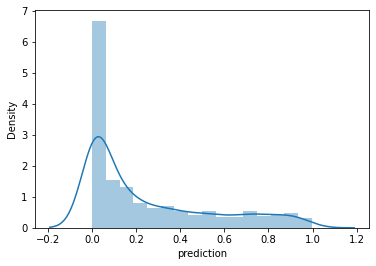

In [93]:
sns.distplot(predictions['prediction'])

### (4) Evaluate
평가를 위해 상위 k개 추천에서 이미 평가된 책을 제거합니다. 순위 측정항목을 계산하려면 모든 user, item pair에 대한 예측이 필요합니다. 사용자가 이미 본 항목은 다시 추천하지 않기로 선택했기 때문에 제거합니다.

rating이 null, 즉 이전에 평가하지 않았던 데이터를 기준으로 추천해 줍니다.

In [94]:
test

,userID,itemID,rating
50,0,50,10
10,0,10,10
22,0,22,1
60,0,60,9
7,0,7,8
...,...,...,...
33860,245,8477,5
33904,246,3194,1
33940,246,15032,8
33896,246,17094,7


In [95]:
merged = pd.merge(train, predictions, on=["userID", "itemID"], how="outer")
test_post = merged[merged['rating'].isnull()].drop('rating', axis=1)

In [96]:
test

,userID,itemID,rating
50,0,50,10
10,0,10,10
22,0,22,1
60,0,60,9
7,0,7,8
...,...,...,...
33860,245,8477,5
33904,246,3194,1
33940,246,15032,8
33896,246,17094,7


In [97]:
from recommenders.evaluation.python_evaluation import (
    map_at_k,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
)

TOP_K = 12

eval_map = map_at_k(test, predictions, col_rating='rating', col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, predictions, col_rating='rating', col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, predictions, col_rating='rating', col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, predictions, col_rating='rating', col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.941629
NDCG:	1.000000
Precision@K:	0.527778
Recall@K:	0.941629


cold starter를 제거하였기 때문에 점수가 높은 모습을 살펴 볼 수 있습니다.

모델을 저장하고, 필요 시 다시 불러와서 사용할 수도 있습니다.

In [98]:
model.save(dir_name=".pretrain/NCF")

---

- Reference
  - 공식 문서
    - [surprise 공식문서](https://surprise.readthedocs.io/en/stable/index.html)
    - [surprise github repository](https://github.com/NicolasHug/Surprise)
    - [implicit 공식문서](https://implicit.readthedocs.io/en/latest/)
    - [implicit github repository](https://github.com/benfred/implicit)
    - [lightfm 공식문서](https://making.lyst.com/lightfm/docs/index.html)
    - [lightfm github repository](https://github.com/lyst/lightfm)
    - [Recommenders 공식문서](https://microsoft-recommenders.readthedocs.io/en/latest/index.html)
    - [Recommenders github](https://github.com/microsoft/recommenders)

  - 참고자료
    - Himanshu Kriplani,Alternating Least Square for Implicit Dataset with code, 2019/6/25, https://towardsdatascience.com/alternating-least-square-for-implicit-dataset-with-code-8e7999277f4b
    - Youwon Jang, LightFM 설명, 2020/06/01, https://greeksharifa.github.io/machine_learning/2020/06/01/LightFM/
    - YounghunJo, [NLP] Surprise library를 활용한 추천시스템 구현하기
, 2020/8/28, https://techblog-history-younghunjo1.tistory.com/117
    - RandomWalker, 5.Surprise 라이브러리를 이용한 추천시스템 개발, 2021/4/10, https://big-dream-world.tistory.com/70
    - Buomsoo Kim, Implementing Matrix Factorization models in Python - Collaborative filtering with Python 14
, 2020/10/22, https://buomsoo-kim.github.io/recommender%20systems/2020/10/22/Recommender-systems-collab-filtering-14.md/

    - susanli2016, Machine-Learning-with-Python, 2018/12/26, https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb

---

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

